In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF or check your setup.")
class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()
    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line
    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()
    def process_data1(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        #print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)     
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue
            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)
            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data1(samples)
                #X_chunk = self.process_data2(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []
#------------------------------------------------------------------------------------------------------
# Minimum Entropy Coupling (MEC) Functions
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))
    #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)
    def body(r, M, J):
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])
        # ensure tensors have same datatype
        a_i = tf.cast(a_i, dtype=tf.int32)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)
        #prepare indices for scatter update
        indices = tf.stack([indices_range, a_i], axis=1)
        #now update
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        J = J + J_updates
        return r_updated, M, J

    def condition(r, M, J):
        return r > 0
    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])
    return J

def apply_mec_to_data(data, num_bins=10, latent_dim=50):
    print('data.shape in apply mec:', data.shape)
    """
    Apply the MEC transformation to each sample in the data using tf.map_fn.
    """
    def process_sample(sample):
        min_val = tf.reduce_min(sample)
        max_val = tf.reduce_max(sample)
        sample_distribution = tf.histogram_fixed_width(sample, [min_val, max_val], nbins=num_bins)
        sample_distribution = tf.cast(sample_distribution, tf.float64)
        sum_distribution = tf.cast(tf.reduce_sum(sample_distribution), tf.float64)
        sample_distribution /= sum_distribution

        mec_transformed = mec_kocaoglu_np(sample_distribution, sample_distribution)

        # Flatten the 2D to 1D
        if len(mec_transformed.shape) > 1:
            transformed_sample = tf.reshape(mec_transformed, [-1])

        # slice/pad to match the latent_dim
        if transformed_sample.shape[0] > latent_dim:
            transformed_sample = transformed_sample[:latent_dim]
        elif transformed_sample.shape[0] < latent_dim:
            padding = tf.zeros(latent_dim - transformed_sample.shape[0], dtype=tf.float64)
            transformed_sample = tf.concat([transformed_sample, padding], axis=0)

        return tf.reshape(transformed_sample, (latent_dim,))
    # apply function to each sample in the batch
    transformed_batch = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)
    return transformed_batch

def process_latent_variables(z):
    z_transformed = apply_mec_to_data(z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)
# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim,
                 epsilon_std=0.1, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        self._build()
        #self._build2()
    def _sampling3(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        z_mean_transformed = process_latent_variables(z_mean)
        epsilon_std = 0.1  # Use a fixed small std deviation to reduce variability
        #epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=K.shape(z_mean_transformed), mean=0., stddev=epsilon_std)
        #epsilon = process_latent_variables(epsilon)
        epsilon = tf.cast(epsilon, 'float64')  # Cast epsilon to float64        
        #a = z_mean_transformed + epsilon
        #return a
        return z_mean_transformed
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
        
    def _build(self):
        # Encoder
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        x = LSTM(50, activation='tanh', return_sequences=True)(inputs)
        self_attention = SelfAttentionLayer(num_heads=2, key_dim=50)  # Adjust num_heads and key_dim as needed
        x = self_attention(x)
        x = LSTM(50, activation='tanh', return_sequences=False)(x)
        z_mean = Dense(50, name='z_mean')(x)
        z_log_var = Dense(50, name='z_log_var')(x)

        #z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        z = Lambda(self._sampling3, output_shape=(50,))([z_mean, z_mean])
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')        
        # Decoder
        latent_inputs = Input(shape=(50,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(50, activation='tanh', return_sequences=True)(x)
        x = LSTM(50, activation='tanh', return_sequences=True)(x)
        final_activation = 'sigmoid' #'linear' if data is not normalized
        outputs = TimeDistributed(Dense(self.feature_dim))(x)
        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def simplified_vae_loss(self, x, x_decoded_mean, z_mean):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        mean_loss = tf.reduce_mean(tf.square(z_mean))
        total_loss = mse + mean_loss
        return K.mean(total_loss)
    
    def compile(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)

    def compile2(self, learning_rate=0.0005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a wrapper function for the custom loss
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.custom_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_custom(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, _, _ = self.encoder(x)
            return self.simplified_vae_loss(x, x_decoded_mean, z_mean)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_simple_autoencoder(self, learning_rate=0.005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)        
        # Simple reconstruction loss
        self.vae.compile(optimizer=optimizer, loss='mse')

# Instantiate and Compile the VAE
sequence_length = 10
feature_dim = 2
original_dim = 100
intermediate_dim = 100
latent_dim = 50

vae_model = VAE(sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
#vae_model.compile2(learning_rate=0.005)
vae_model.compile_simple_autoencoder(learning_rate=0.005)
#vae_model.compile_custom(learning_rate=0.005)

# Model Training
batch_size = 100
max_train_samples = 3000000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 3000000  # Maximum samples to read (or None to read all)
max_test_samples = 3000000

pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# Example file patterns
#pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
#mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# Data Generator Instances
# train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
#                                    max_samples=max_train_samples, for_training=True)
# combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
#                                       for_training=False)
with tf.device('/cpu:0'):
    train_gen_instance = DataGenerator(pure_file_new, batch_size=batch_size, sequence_length=sequence_length, 
                                       max_samples=max_train_samples, for_training=True)

train_dataset = tf.data.Dataset.from_generator(
    lambda: (data for data in train_gen_instance),
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, sequence_length, feature_dim], [None, sequence_length, feature_dim])
).prefetch(tf.data.experimental.AUTOTUNE)


num_epochs = 4  # Number of epochs
steps_per_epoch = train_steps  # Number of steps per epoch

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Directly use TensorFlow's Dataset API to handle batching and iteration
    for step, (X_chunk, Y_chunk) in zip(range(steps_per_epoch), train_dataset):
        # Train on batch
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)

        if step % 100 == 0:
            print(f"Step {step + 1}/{steps_per_epoch}, Loss: {loss}")
    print()


# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     train_gen_instance.reset()  # Ensure the generator is reset at the start of each epoch

#     for step in range(steps_per_epoch):
#         try:
#             X_chunk, Y_chunk = next(train_gen_instance)
#             loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
#             if step % 100 == 0:
#                 print(f"Step {step + 1}/{steps_per_epoch}, Loss: {loss}")
#         except StopIteration:
#             # This catches the end of the dataset
#             print("End of dataset reached.")
#             break
#     print()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        #loss = model.train_on_batch(X_chunk, Y_chunk)
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()

with tf.device('/cpu:0'):
    combined_gen_instance = DataGenerator(mixed_file_new, batch_size=batch_size, sequence_length=sequence_length, 
                                          for_training=False)  # Assuming for_training=False modifies behavior suitably for prediction

combined_dataset = tf.data.Dataset.from_generator(
    lambda: (data for data in combined_gen_instance),
    output_types=tf.float32,  # Adjust based on the actual data types
    # Here, you might only need the input shapes if you're just doing predictions
    output_shapes=([None, sequence_length, feature_dim])
).prefetch(tf.data.experimental.AUTOTUNE)

num_predictions = 500  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")


reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []

combined_gen_instance.reset()

for step, X_chunk_test in enumerate(combined_dataset.take(num_predictions)):
    print(f'Prediction number: {step+1}')
    X_chunk_pred = vae_model.vae.predict(X_chunk_test)
    chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
    reconstruction_errors.extend(chunk_errors)
    all_X_chunk_test.append(X_chunk_test.numpy())  # Storing test data
    all_X_chunk_pred.append(X_chunk_pred)  # Storing predictions

    if step % 100 == 0:
        print(f"Processed {step + 1}/{num_predictions} predictions")
    
# try:
#     for _ in range(num_predictions):
#         print('prediction number:', _)
#         X_chunk_test = next(combined_gen_instance)
#         #X_chunk_pred = model.predict(X_chunk_test)
#         X_chunk_pred = vae_model.vae.predict(X_chunk_test)
#         chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
#         reconstruction_errors.extend(chunk_errors)        
#         all_X_chunk_test.append(X_chunk_test)
#         all_X_chunk_pred.append(X_chunk_pred)
# except StopIteration:
#     print("All samples processed.")


reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

print('max_error_per_sequence.shape:', max_error_per_sequence.shape)

threshold1 = np.percentile(max_error_per_sequence, 98)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)

#is_intrusion_detected2 = error_per_sequence > threshold1

num_total_sequences = len(max_error_per_sequence)
num_total_sequences2 = num_predictions * batch_size - num_predictions
print('num_total_sequences:', num_total_sequences)
print('num_total_sequences2:', num_total_sequences2)

#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = max_error_per_sequence.flatten()
#flat_error_per_sequence2 = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)

#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")




2024-04-11 09:52:19.313956: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 09:52:19.314968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 09:52:19.340202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 09:52:19.340637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 09:52:19.733962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Num GPUs Available:  0
Please install GPU version of TF or check your setup.


2024-04-11 09:52:20.720054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 09:52:20.721397: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-11 09:52:20.722222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

data.shape in apply mec: (None, 50)
Instructions for updating:
Use fn_output_signature instead
data.shape in apply mec: (None, 50)
File extension detected: 
Epoch 1/4
data.shape in apply mec: (990, 50)
data.shape in apply mec: (990, 50)
Step 1/3000, Loss: 0.9976323843002319
Step 101/3000, Loss: 0.9857910871505737
Step 201/3000, Loss: 0.9781239032745361
Step 301/3000, Loss: 0.981461763381958
Step 401/3000, Loss: 0.963373601436615
Step 501/3000, Loss: 0.928148090839386
Step 601/3000, Loss: 0.980508029460907
Step 701/3000, Loss: 0.9183703064918518
Step 801/3000, Loss: 0.8902602195739746
Step 901/3000, Loss: 0.9581161141395569
Step 1001/3000, Loss: 0.9704414010047913
Step 1101/3000, Loss: 0.9603456258773804
Step 1201/3000, Loss: 0.978364884853363
Step 1301/3000, Loss: 1.0048940181732178
Step 1401/3000, Loss: 1.0257126092910767
Step 1501/3000, Loss: 0.8954993486404419
Step 1601/3000, Loss: 0.9491877555847168
Step 1701/3000, Loss: 0.9551271796226501
Step 1801/3000, Loss: 0.8934534788131714
S

Step 1801/3000, Loss: 0.9382851719856262
Step 1901/3000, Loss: 0.6932421922683716
Step 2001/3000, Loss: 1.0293500423431396
Step 2101/3000, Loss: 0.5652182102203369
Step 2201/3000, Loss: 0.47870856523513794
Step 2301/3000, Loss: 0.4536519944667816
Step 2401/3000, Loss: 0.8898820281028748
Step 2501/3000, Loss: 0.9293738007545471
Step 2601/3000, Loss: 0.7276117205619812
Step 2701/3000, Loss: 0.6856881380081177
Step 2801/3000, Loss: 1.0132062435150146
Step 2901/3000, Loss: 0.9802249073982239

Epoch 3/4
File extension detected: 
Step 1/3000, Loss: 0.5506642460823059
Step 101/3000, Loss: 0.5856497883796692
Step 201/3000, Loss: 0.9116725921630859
Step 301/3000, Loss: 0.9044815301895142
Step 401/3000, Loss: 0.638007640838623
Step 501/3000, Loss: 0.924308717250824
Step 601/3000, Loss: 0.9780993461608887
Step 701/3000, Loss: 1.0091257095336914
Step 801/3000, Loss: 0.4896259903907776
Step 901/3000, Loss: 0.37119564414024353
Step 1001/3000, Loss: 0.9137263298034668
Step 1101/3000, Loss: 0.88713282

31/31 [==============================] - 0s 7ms/step
Prediction number: 69
31/31 [==============================] - 0s 7ms/step
Prediction number: 70
31/31 [==============================] - 0s 7ms/step
Prediction number: 71
31/31 [==============================] - 0s 7ms/step
Prediction number: 72
31/31 [==============================] - 0s 7ms/step
Prediction number: 73
31/31 [==============================] - 0s 7ms/step
Prediction number: 74
31/31 [==============================] - 0s 7ms/step
Prediction number: 75
31/31 [==============================] - 0s 7ms/step
Prediction number: 76
31/31 [==============================] - 0s 7ms/step
Prediction number: 77
31/31 [==============================] - 0s 7ms/step
Prediction number: 78
31/31 [==============================] - 0s 7ms/step
Prediction number: 79
31/31 [==============================] - 0s 7ms/step
Prediction number: 80
31/31 [==============================] - 0s 7ms/step
Prediction number: 81
31/31 [==================

31/31 [==============================] - 0s 7ms/step
Prediction number: 177
31/31 [==============================] - 0s 7ms/step
Prediction number: 178
31/31 [==============================] - 0s 7ms/step
Prediction number: 179
31/31 [==============================] - 0s 7ms/step
Prediction number: 180
31/31 [==============================] - 0s 7ms/step
Prediction number: 181
31/31 [==============================] - 0s 7ms/step
Prediction number: 182
31/31 [==============================] - 0s 7ms/step
Prediction number: 183
31/31 [==============================] - 0s 7ms/step
Prediction number: 184
31/31 [==============================] - 0s 7ms/step
Prediction number: 185
31/31 [==============================] - 0s 7ms/step
Prediction number: 186
31/31 [==============================] - 0s 7ms/step
Prediction number: 187
31/31 [==============================] - 0s 7ms/step
Prediction number: 188
31/31 [==============================] - 0s 7ms/step
Prediction number: 189
31/31 [=====

31/31 [==============================] - 0s 7ms/step
Prediction number: 284
31/31 [==============================] - 0s 7ms/step
Prediction number: 285
31/31 [==============================] - 0s 7ms/step
Prediction number: 286
31/31 [==============================] - 0s 7ms/step
Prediction number: 287
31/31 [==============================] - 0s 7ms/step
Prediction number: 288
31/31 [==============================] - 0s 7ms/step
Prediction number: 289
31/31 [==============================] - 0s 7ms/step
Prediction number: 290
31/31 [==============================] - 0s 7ms/step
Prediction number: 291
31/31 [==============================] - 0s 7ms/step
Prediction number: 292
31/31 [==============================] - 0s 7ms/step
Prediction number: 293
31/31 [==============================] - 0s 7ms/step
Prediction number: 294
31/31 [==============================] - 0s 7ms/step
Prediction number: 295
31/31 [==============================] - 0s 7ms/step
Prediction number: 296
31/31 [=====

31/31 [==============================] - 0s 7ms/step
Prediction number: 391
31/31 [==============================] - 0s 7ms/step
Prediction number: 392
31/31 [==============================] - 0s 7ms/step
Prediction number: 393
31/31 [==============================] - 0s 7ms/step
Prediction number: 394
31/31 [==============================] - 0s 7ms/step
Prediction number: 395
31/31 [==============================] - 0s 7ms/step
Prediction number: 396
31/31 [==============================] - 0s 7ms/step
Prediction number: 397
31/31 [==============================] - 0s 7ms/step
Prediction number: 398
31/31 [==============================] - 0s 7ms/step
Prediction number: 399
31/31 [==============================] - 0s 7ms/step
Prediction number: 400
31/31 [==============================] - 0s 7ms/step
Prediction number: 401
31/31 [==============================] - 0s 7ms/step
Processed 401/500 predictions
Prediction number: 402
31/31 [==============================] - 0s 7ms/step
Predi

31/31 [==============================] - 0s 7ms/step
Prediction number: 498
31/31 [==============================] - 0s 7ms/step
Prediction number: 499
31/31 [==============================] - 0s 7ms/step
Prediction number: 500
31/31 [==============================] - 0s 7ms/step
reconstruction_error.shape: (495000, 2)
Number of NaNs in reconstruction_error: 0
max_error_per_sequence: [0.72050524 0.95374215 0.77258074 ... 1.170776   1.1348727  1.2769415 ]
max_error_per_sequence.shape: (495000,)
threshold1: 2.492251133918765
threshold percentile: 1.7662173211574548
len(is_intrusion_detected): 495000
is_intrusion_detected.shape: (495000,)
num_total_sequences: 495000
num_total_sequences2: 49500
        Part  True Count  False Count
0       Real        6452       488548
1  Imaginary        6983       488017
2    Overall       13435       976565
Number of jamming sequences detected: 13435 out of 990000 sequences


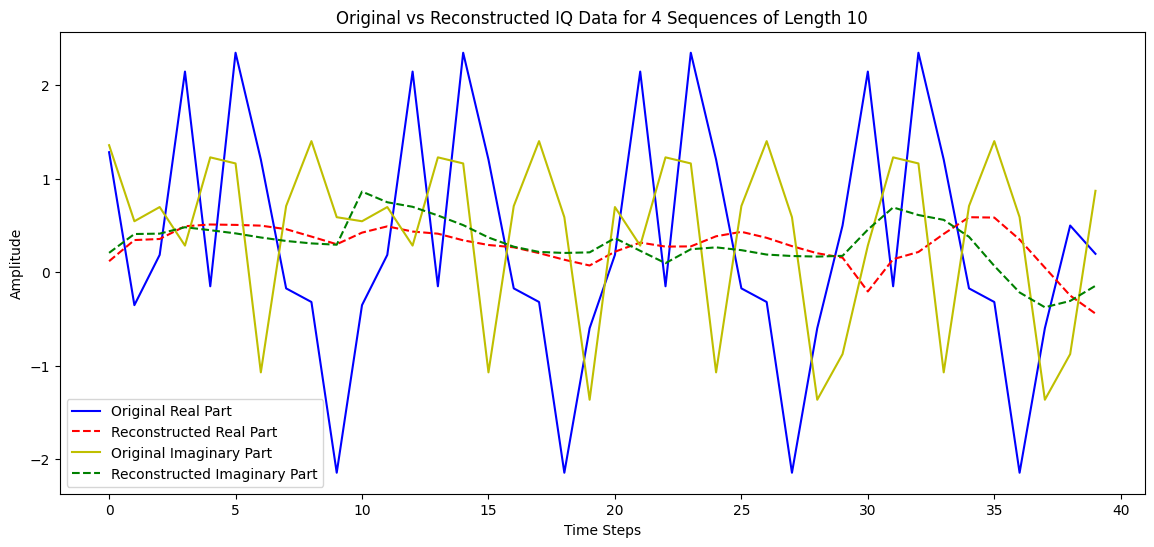

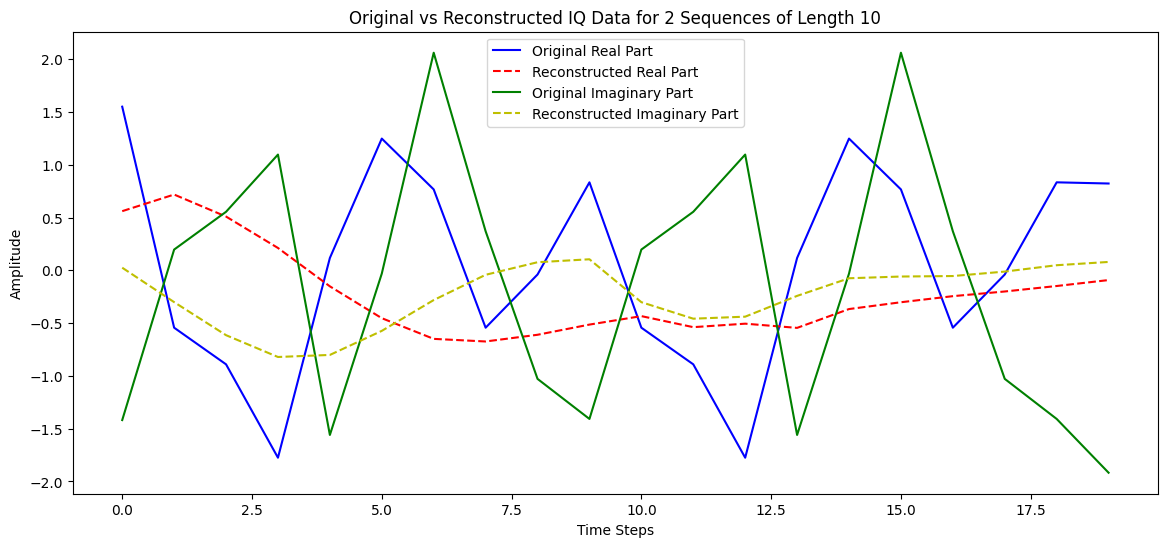

In [2]:
# # Define the number of sequences to plot together
n = 4  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

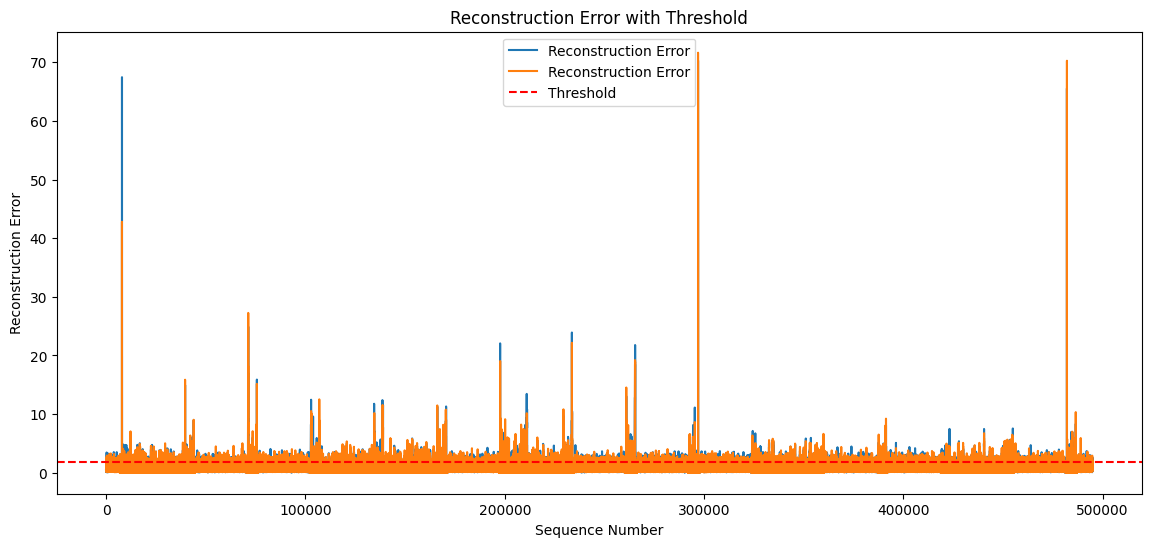

In [3]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

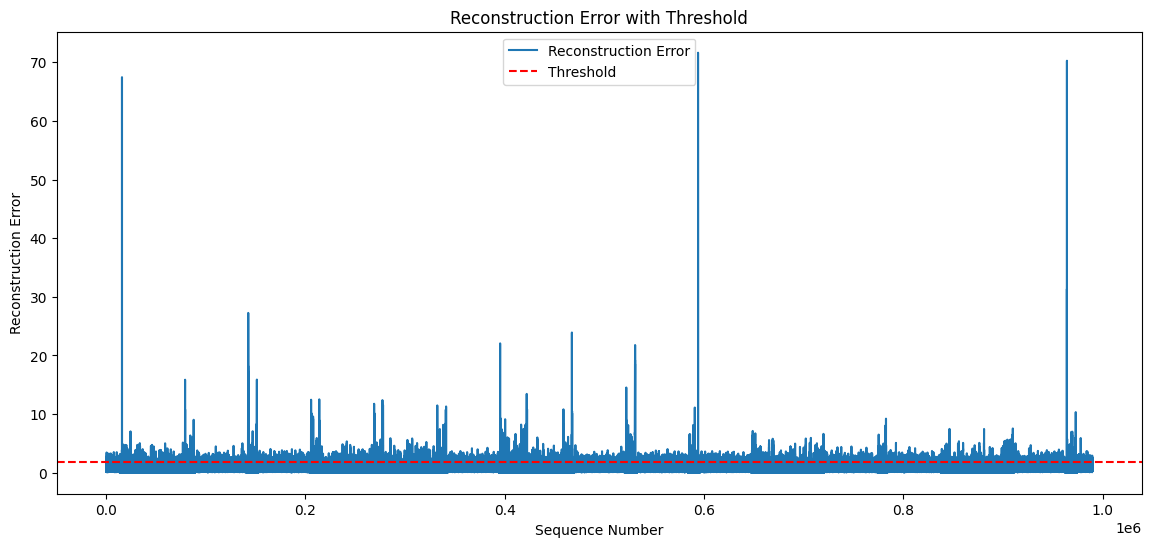

In [4]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


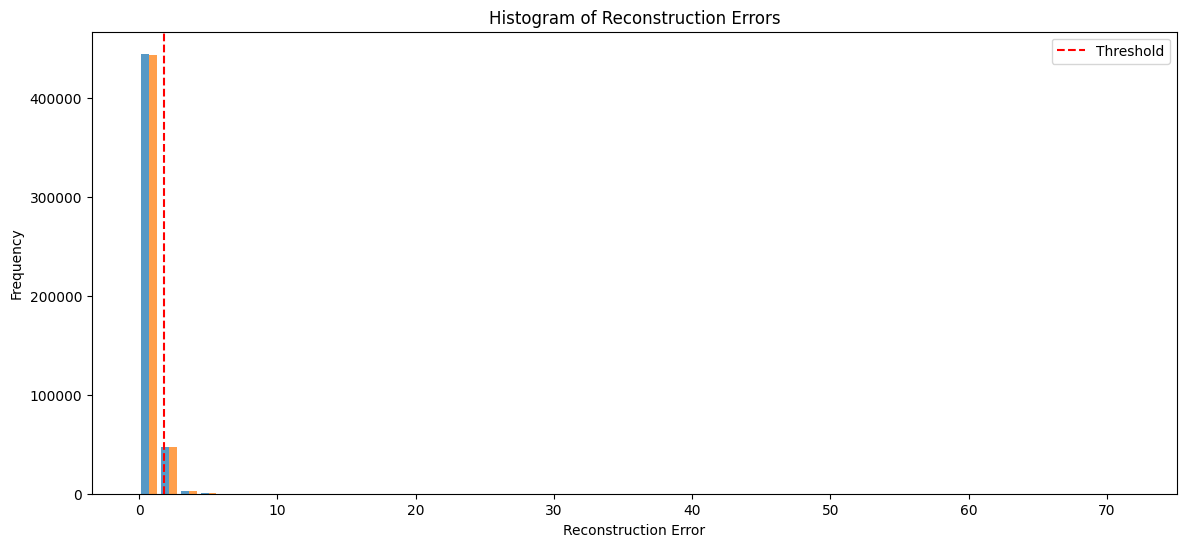

In [5]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


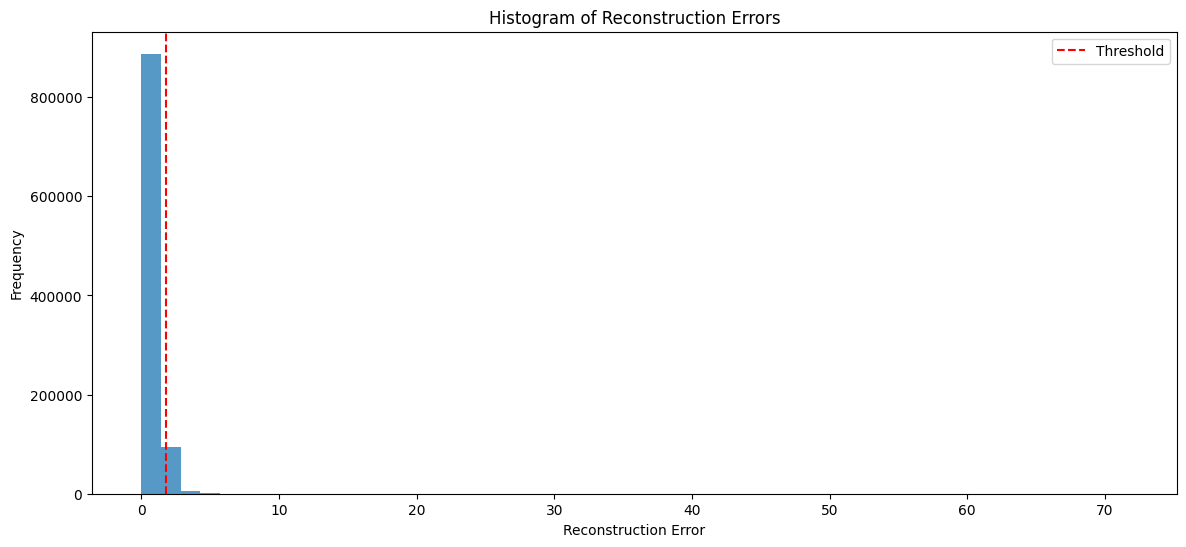

In [6]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

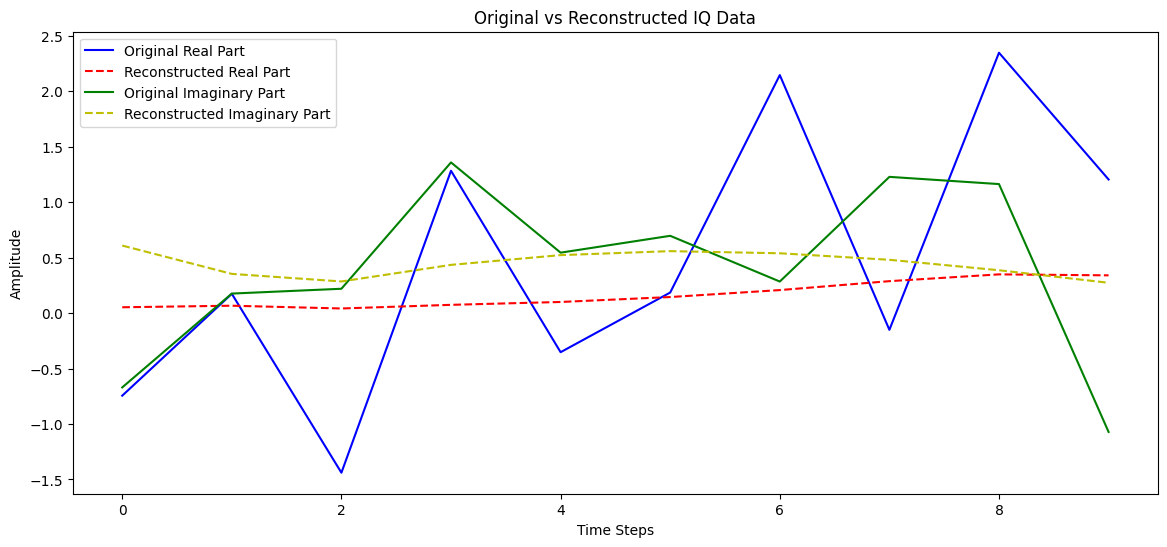

In [7]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()


Shape of avg_real: (990,)
Shape of avg_imag: (990,)
Shape of last_errors: 990


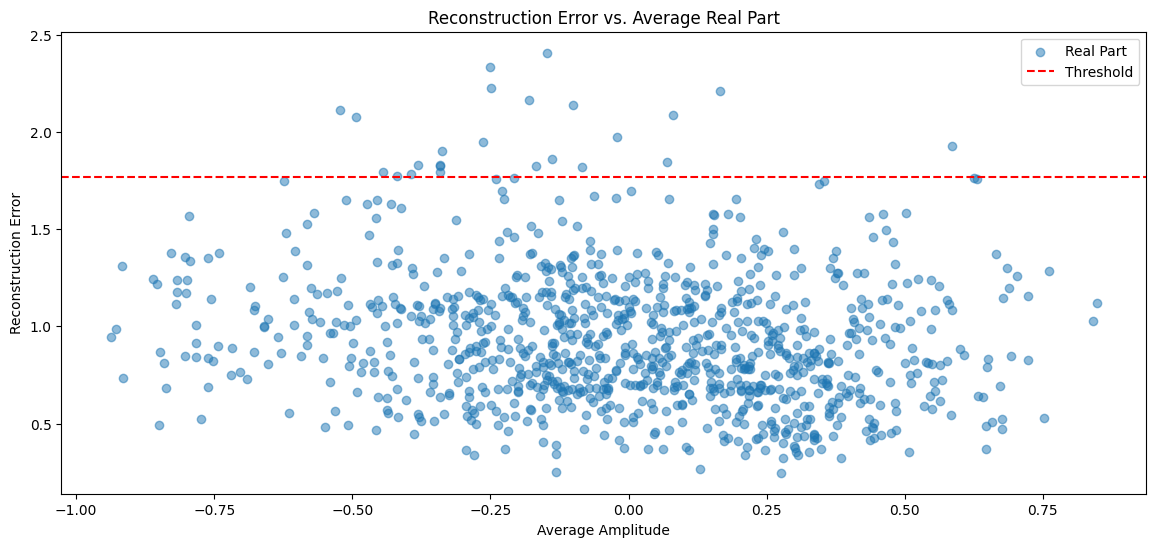

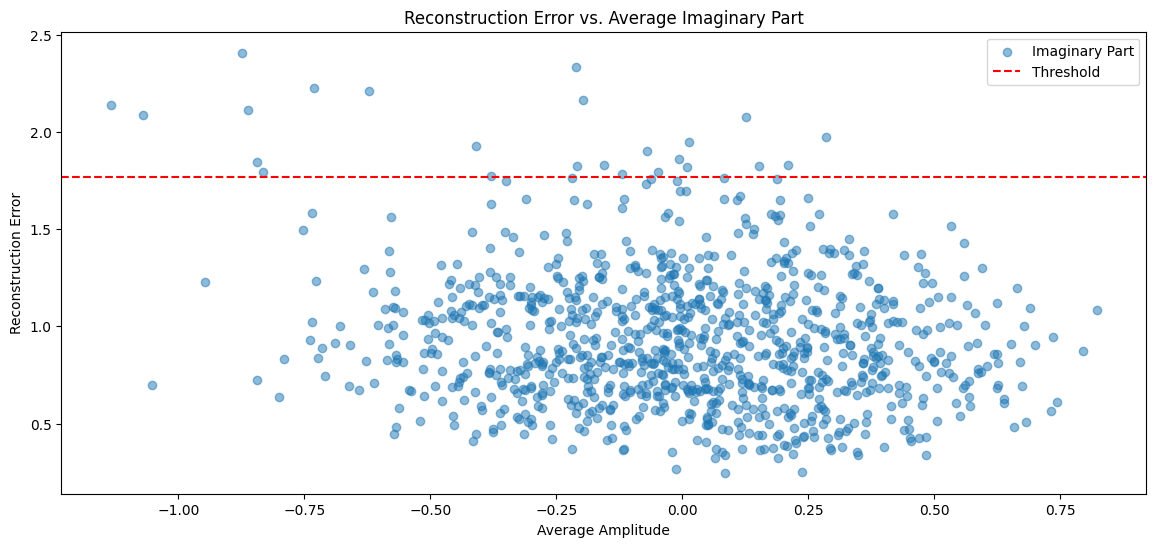

In [8]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

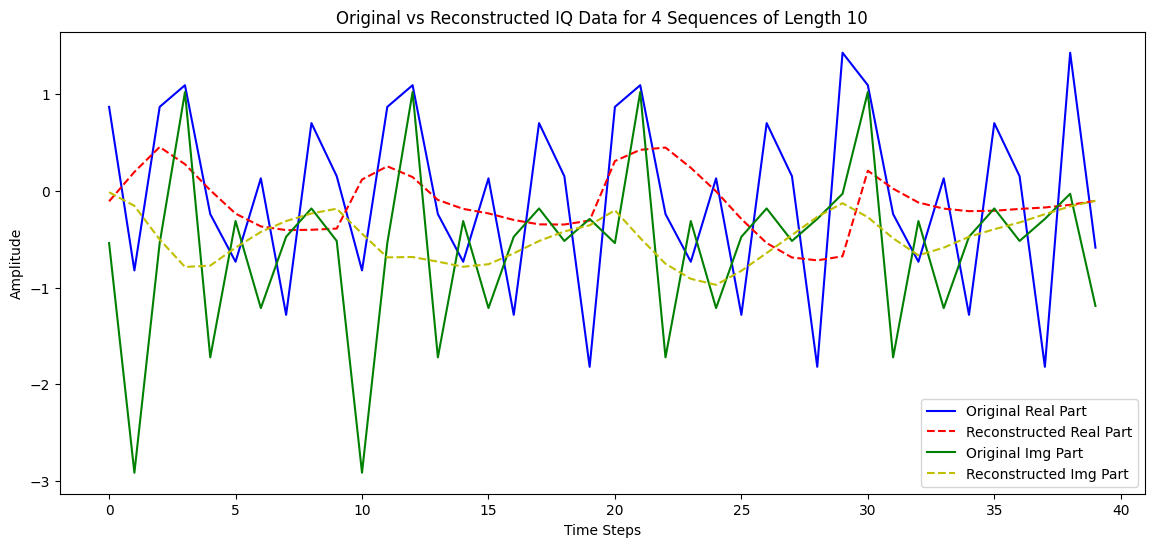

In [9]:
# # Define the number of sequences to plot together
n = 4  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Img Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Img Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

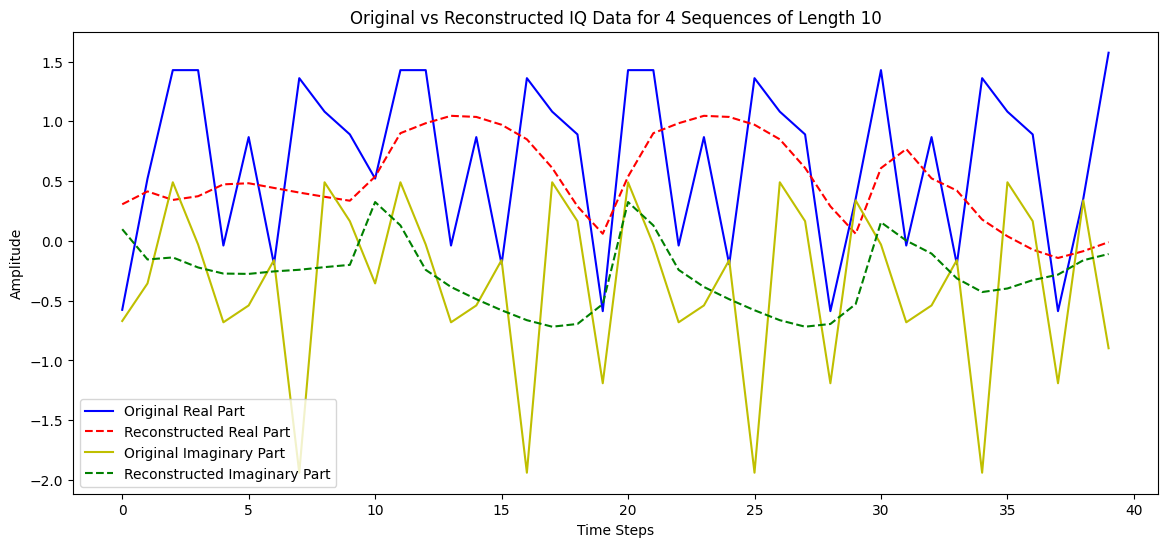

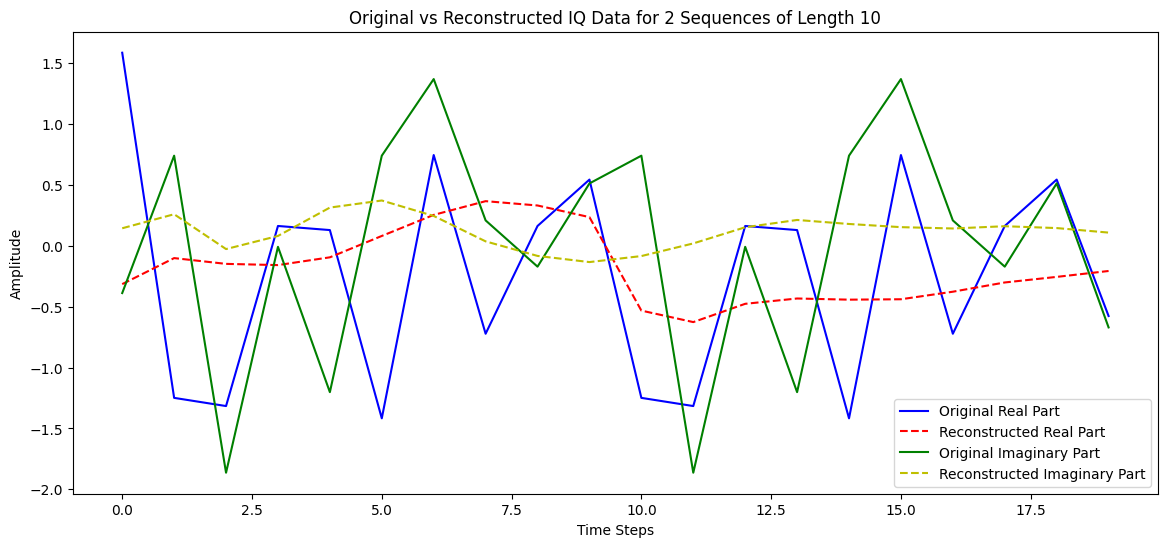

In [10]:
# # Define the number of sequences to plot together
n = 4  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

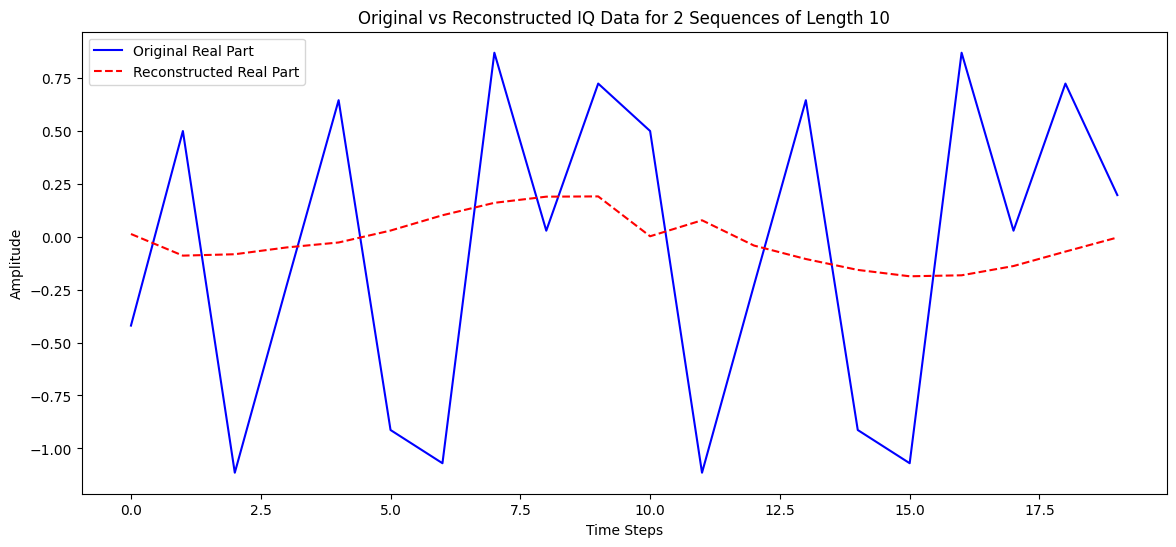

In [11]:
# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')

plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

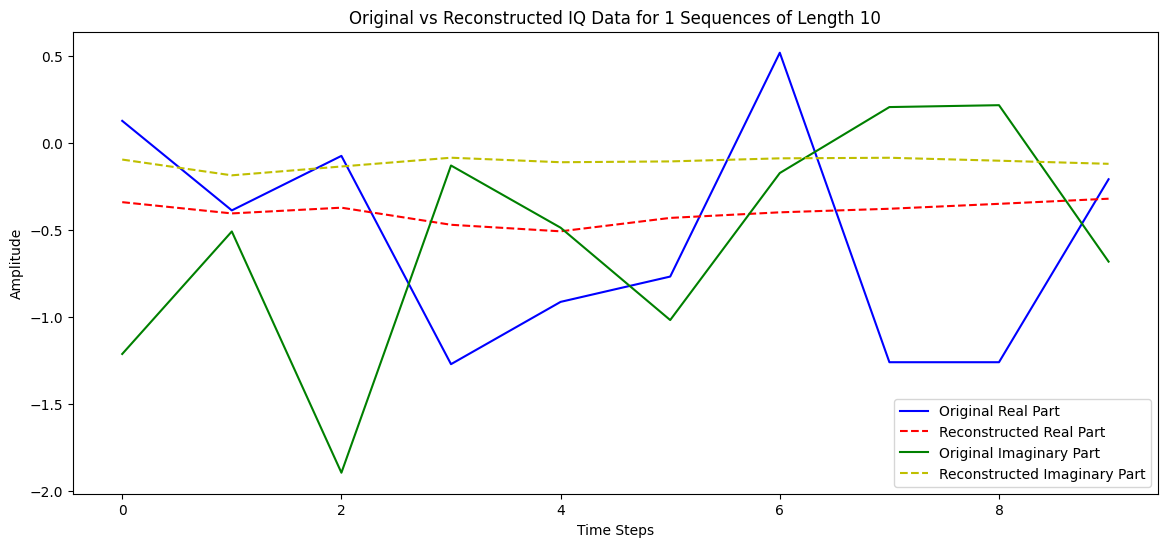

In [12]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

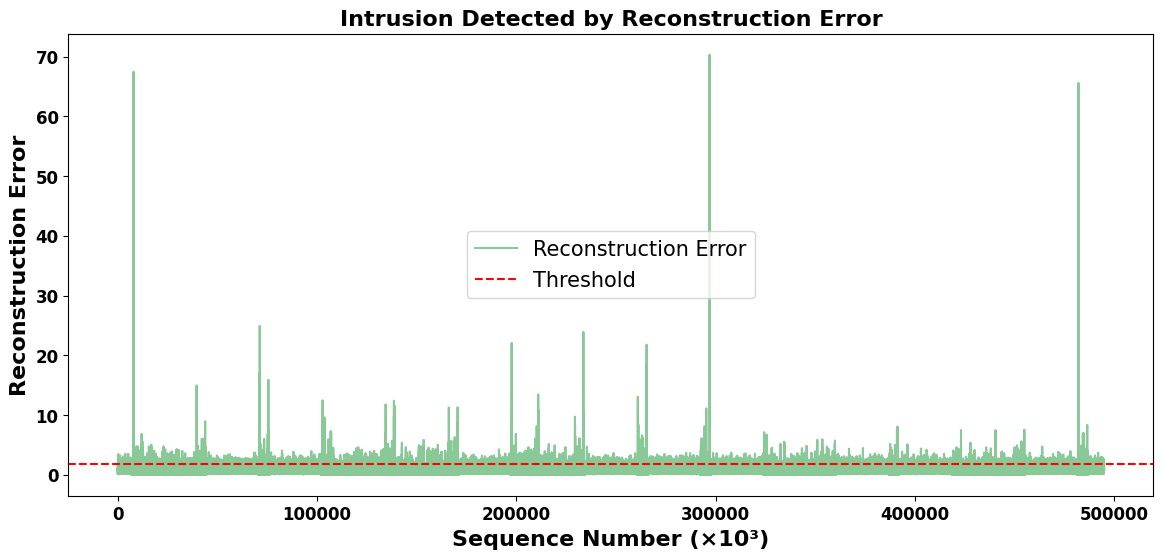

In [13]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

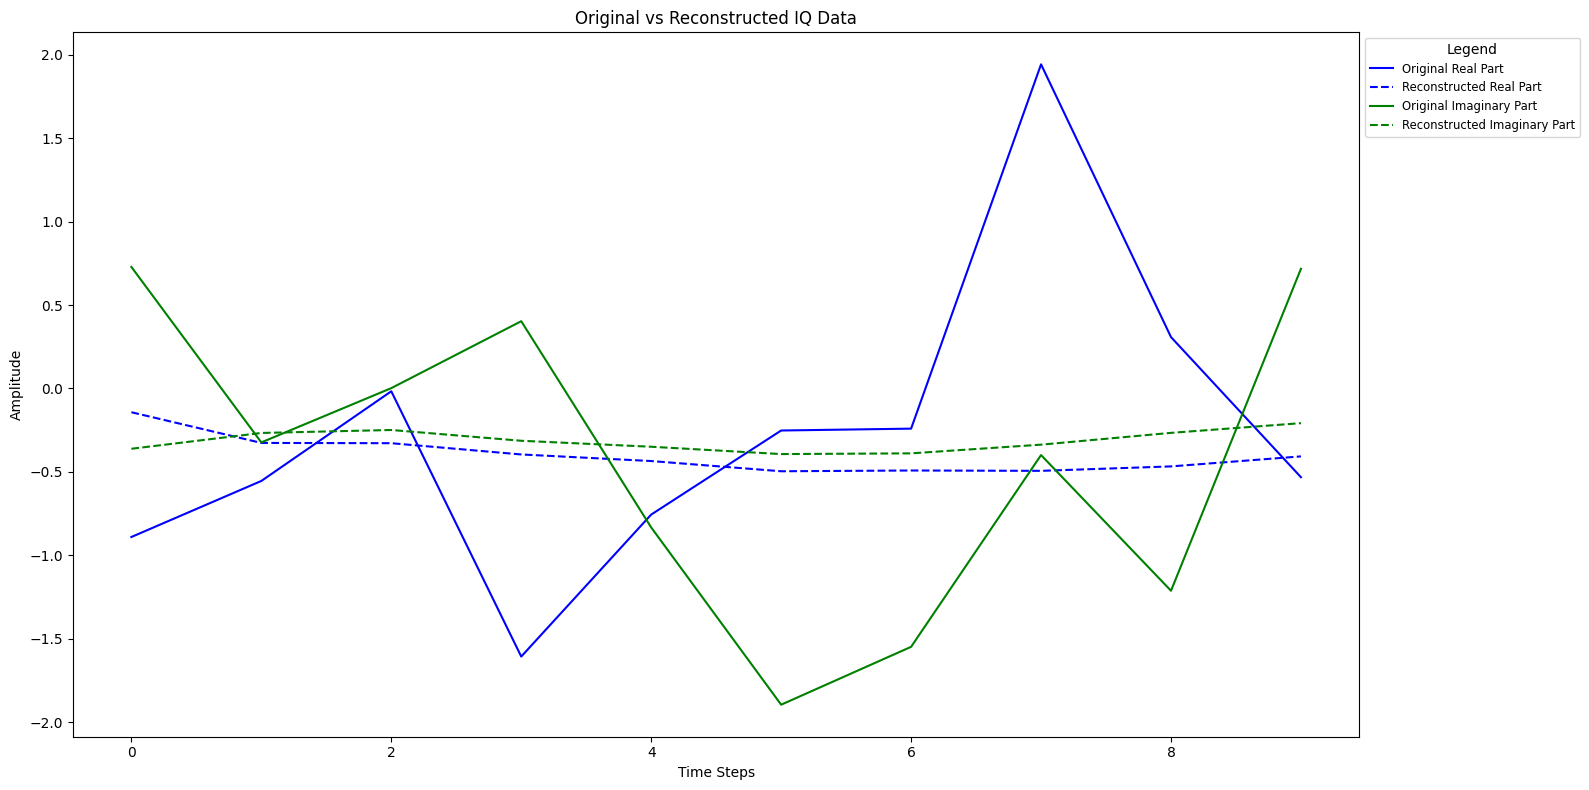

In [14]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [15]:
reconstruction_error_real_parts = reconstruction_error[:, 0]
reconstruction_error_real_std = reconstruction_error[:, 1]
reconstruction_error_real_skew = reconstruction_error[:, 2]
reconstruction_error_real_kurtosis = reconstruction_error[:, 3]
reconstruction_error_imag_parts = reconstruction_error[:, 4]
reconstruction_error_imag_std = reconstruction_error[:, 5]
reconstruction_error_imag_skew = reconstruction_error[:, 6]
reconstruction_error_imag_kurtosis = reconstruction_error[:, 7]


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
# plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
# plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

# plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
# plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [ ]:
# # Define the number of sequences to plot together
n = 2  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 4], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 4  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 2], 'b-', label='Original Real Part Skew')
plt.plot(reconstructed_sample[:, 2], 'r--', label='Reconstructed Real Part Skew')
plt.plot(original_sample[:, 6], 'g-', label='Original Imaginary Part Skew')
plt.plot(reconstructed_sample[:, 6], 'y--', label='Reconstructed Imaginary Part Skew')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 4  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 3], 'b-', label='Original Real Part Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'r--', label='Reconstructed Real Part Kurtosis')
plt.plot(original_sample[:, 7], 'g-', label='Original Imaginary Part Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'y--', label='Reconstructed Imaginary Part Kurtosis')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()